In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn

several different ways to go about this: 
1. ROI spheres: take the center coordinates, pick a radius around it and then just use the average time series data (1 value) for the whole sphere in first/second level
2. Neurosynth derived DMN mask: methods/mask taken from this paper here: https://www.nature.com/articles/s41598-020-72317-8#Abs1
    Using niftimasker to extract average time-series within ROIs 
4. Resting state derived DMN mask: use pcc as a seed region for resting state, localize co-activated regions and then use as binarized mask:
   https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_adhd_dmn.html


In [14]:
# ROI spheres (method 1/2) 
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)]
labels = [
    "Posterior Cingulate Cortex",
    "Left Temporoparietal junction",
    "Right Temporoparietal junction",
    "Medial prefrontal cortex",
]

#msdl atlas: 
dmn_coords_msdl = [(-45.8, -64.78, 31.84),(-0.2, -55.21, 29.87),(-0.15, 51.42, 7.58),(51.66, -59.34, 28.88)]
labels_msdl = [
        'L DMN',
        'Med DMN',
        'Front DMN',
        'R DMN',
]
# manually entered coordinates -- could probably do some sort of extraction using resting state data! 

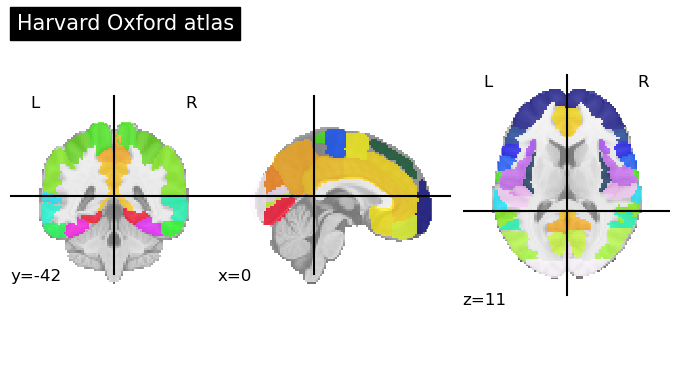

In [42]:
import numpy as np
from nilearn.datasets import fetch_atlas_harvard_oxford
dataset_ho = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
atlas_ho_filename = dataset_ho.filename
plotting.plot_roi(atlas_ho_filename, title="Harvard Oxford atlas")

In [202]:
#tutorial for this: https://neurostars.org/t/create-a-10mm-sphere-roi-mask-around-a-given-coordinate/28853/3

# creating template images for plotting / first-level masks 
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=dmn_coords,
    niimg=None,
    radius=10,
    allow_overlap=False, 
    mask_img=space_defining_image)

A = A.sum(axis=0)
A = np.array(A).flatten()

sphere_mask = _unmask_3d(A,mask=space_defining_image.get_fdata().astype(bool))
sphere_mask = Nifti1Image(sphere_mask, space_defining_image.affine)


# can use masker to create 1 value per sphere 
from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
    dmn_coords,
    radius=8,
    t_r=2.5,
    mask_img=space_defining_image
)

In [253]:
# method 3: neurosynth DMN mask: 
from nilearn.image import resample_to_img 
# We extract data from ROIs using nilearn's NiftiLabelsMasker
from nilearn.maskers import NiftiLabelsMasker

#import DMN Neurosynth mask:
dmn_mask_raw = load_img('/Volumes/Seagate Desktop Drive/kdata/DMN masks/DMN.nii.gz')
dmn_labels = resample_to_img(source_img=dmn_mask_raw, target_img=space_defining_image, interpolation='nearest')

# First, initialize masker 
masker = NiftiLabelsMasker(
    dmn_labels, mask_img=space_defining_image
)

#average signal across DMN regions (PCC, mPFC, lTPJ, rTPJ)
# dmn_data = dmn_mask4.get_fdata()
# binarized_data = (dmn_data > 0).astype(bool)
# dmn_avg_mask = Nifti1Image(binarized_data, dmn_mask4.affine, header=dmn_mask4.header)


In [16]:
# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/kdata/'
os.chdir(path)
output_dir = Path.cwd() / "results" / "surface" / "first_level_results"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

#isolating directory called layout_raw (for events.tsv files) -- will change depending on where data is stored / what computer we're running on
layout_raw = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/', validate=True)

#isolating directory called layout (for fMRIprep derivatives) -- will change depending on where data is stored / what computer we're running on 
layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

Output will be saved to: /Volumes/Seagate Desktop Drive/kdata/results/surface/first_level_results
BIDS Layout: ...esktop Drive/kdata/derivatives | Subjects: 58 | Sessions: 110 | Runs: 174


In [17]:
# needed for making design matrix 
# note: keep MNI files for isolating tr / frames bc easier to load 
def load_bids_events(layout,layout_raw, subject, run, session):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = 2.5 #put in manually bc get_tr wouldn't work?? 
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task='selfother',session = session,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files[run])
    n_tr = func_file.shape[-1]

    onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events', session = session)[run].path)
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as "onsets_actua
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [196]:
# subjects missing ses02:
# 102, 138, 145, 209, 221, 237 
subjects = layout.get_subjects()
subjects2 = []
subjects2 = subjects
#subjects2 = subjects
#testing second level (removing all subs with errors) 
del(subjects2[0]) #- 102 
del(subjects2[21]) #- 138 +1
del(subjects2[25]) #- 145 +1 
del(subjects2[32]) #- 209 +1 
del(subjects2[40]) #- 221 +1 
del(subjects2[50]) #- 237 +2 

subjects = layout.get_subjects()

Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...
self-other: Z-score outputs: [ 1.45309418  1.17329039  1.43437047 -0.37263669]


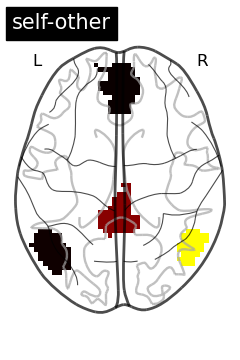

self-fix: Z-score outputs: [-0.26138535 -1.14125957 -1.16323633 -1.20563335]


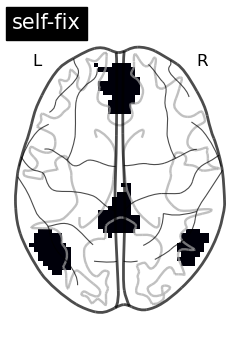

other-fix: Z-score outputs: [-2.0224516  -2.54173878 -2.88516008 -0.74411921]


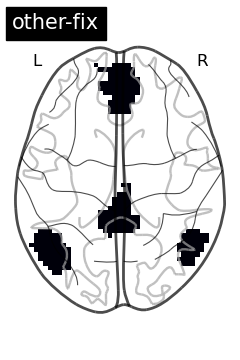

case-fix: Z-score outputs: [-0.22825313 -1.44005593 -2.38649861  0.87303672]


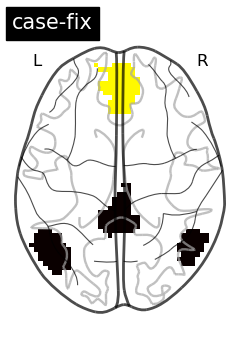

In [255]:
# Method 1: just running first level on ROI spheres, then interpolating back to the nifti image -- 1 average value for the ROI 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

dmn_time_series = []
for con_img in fmri_imgs:
    dmn_time_series.append(masker.fit_transform(con_img))
dmn_time_series = np.concatenate(dmn_time_series, axis = 0)

confound_files = layout.get(subject=sub,
                datatype='func', task='selfother',session = sess,
                desc='confounds',
               extension="tsv",
               return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
#36 confound_vars 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                   'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                     'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                     'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                     'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                     'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                     'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                     'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                    ]

final_confounds = confound_vars

design_matrices = []

print("Creating First Level Design matrix ... ")

for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list / concatenate 
    design_matrices.append(design_matrix)
design_matrix_allruns = []    
design_matrix_allruns = np.concatenate(design_matrices, axis = 0)

print("First Level Design Matrix completed")

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(design_matrix.columns)
}

contrasts = {
    "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
    "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
    "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
    "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

}

print("Fitting first-level GLM ...")

#fmri_glm = FirstLevelModel()
labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):

# compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val)

    z_score = contrast.z_score()
    print(f"{contrast_id}: Z-score outputs: {z_score}") 
    plotimg = masker.inverse_transform(z_score)

    plotting.plot_glass_brain(
            plotimg,
            display_mode="z",
            title=contrast_id,
            )
    plotting.show()
    

Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 3 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


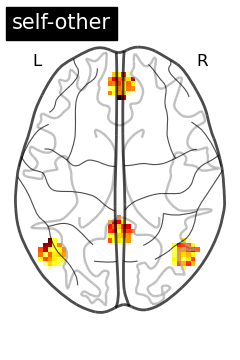

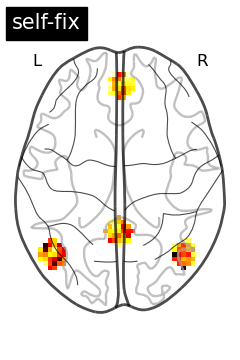

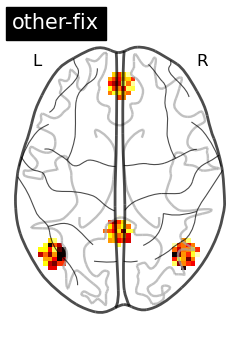

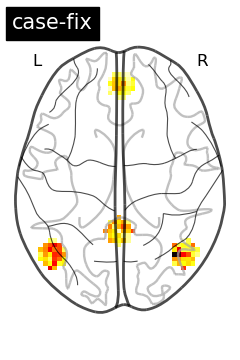

In [222]:
# Method 2: applying binary mask of ROI sphere regions to first level -- values able to vary within the ROI sphere 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

confound_files = layout.get(subject=sub,
                datatype='func', task='selfother',session = sess,
                desc='confounds',
               extension="tsv",
               return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
#36 confound_vars 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                   'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                     'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                     'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                     'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                     'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                     'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                     'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                    ]

final_confounds = confound_vars

design_matrices = []

print("Creating First Level Design matrix ... ")

for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list / concatenate 
    design_matrices.append(design_matrix)
design_matrix_allruns = []    
design_matrix_allruns = np.concatenate(design_matrices, axis = 0)

print("First Level Design Matrix completed")

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(design_matrix.columns)
}

contrasts = {
    "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
    "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
    "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
    "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

}

print("Fitting first-level GLM ...")

#fmri_glm = FirstLevelModel()
fmri_glm = FirstLevelModel(mask_img = sphere_mask)
#no gm mask 
#fmri_glm = FirstLevelModel()

fmri_glm = fmri_glm.fit(fmri_imgs, design_matrices=design_matrices)

# Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
#print(f"\tcontrast id: {contrast_id}")
# compute the contrasts
    outputs = fmri_glm.compute_contrast(contrast_val, output_type='all')
# plot the contrasts as soon as they're generated
# the display is overlaid on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
    #print(f"{contrast_id}: Z-score outputs: {z_score}") 
    plotting.plot_glass_brain(
        outputs['z_score'],
        display_mode="z",
        title=contrast_id,
    )
    plotting.show()
 

Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...


/Users/angelafang/opt/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 3 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


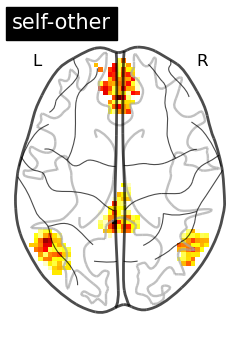

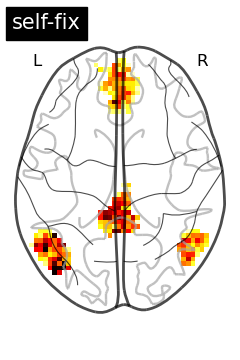

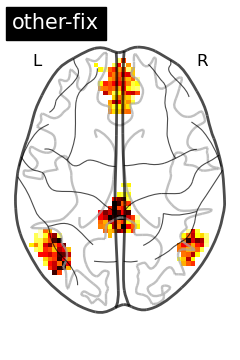

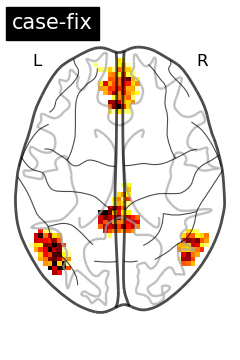

In [223]:
# Method 3: applying binary mask of Neurosynth DMN regions to first level -- values able to vary within the ROI sphere 

sess = '01'
sub = '102'
fmri_imgs = layout.get(subject=sub,
            datatype='func', task='selfother',session = sess,
            desc='preproc',
            space='MNI152NLin2009cAsym',
            extension='nii.gz',
           return_type='file')
hrf_model = "spm" #canonical hrf 
high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

confound_files = layout.get(subject=sub,
                datatype='func', task='selfother',session = sess,
                desc='confounds',
               extension="tsv",
               return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
#36 confound_vars 
confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                   'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                     'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                     'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                     'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                     'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                     'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                     'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                    ]

final_confounds = confound_vars

design_matrices = []

print("Creating First Level Design matrix ... ")

for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
    run = idx
    events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
# Define the sampling times for the design matrix
    frame_times = np.arange(n_scans) * tr
    confound_file = confound_files[run]
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[final_confounds]
    confound_df.fillna(0, inplace=True)
# Build design matrix with the previously defined parameters
    design_matrix = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        drift_model="polynomial",
        drift_order=3,
        add_regs=confound_df,
        add_reg_names=confound_vars,
        high_pass=high_pass,
    )
    design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
    if idx == 0:
        design_matrix['intercept1'] = 1 
        design_matrix['intercept2'] = 0
        design_matrix['intercept3'] = 0
    elif idx == 1:
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 1 
        design_matrix['intercept3'] = 0
    else: 
        design_matrix['intercept1'] = 0
        design_matrix['intercept2'] = 0 
        design_matrix['intercept3'] = 1
# put the design matrices in a list / concatenate 
    design_matrices.append(design_matrix)
design_matrix_allruns = []    
design_matrix_allruns = np.concatenate(design_matrices, axis = 0)

print("First Level Design Matrix completed")

contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(design_matrix.columns)
}

contrasts = {
    "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
    "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
    "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
    "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

}

print("Fitting first-level GLM ...")

#fmri_glm = FirstLevelModel()
fmri_glm = FirstLevelModel(mask_img = dmn_mask)
#no gm mask 
#fmri_glm = FirstLevelModel()

fmri_glm = fmri_glm.fit(fmri_imgs, design_matrices=design_matrices)

# Iterate on contrasts
for contrast_id, contrast_val in contrasts.items():
#print(f"\tcontrast id: {contrast_id}")
# compute the contrasts
    outputs = fmri_glm.compute_contrast(contrast_val, output_type='all')
# plot the contrasts as soon as they're generated
# the display is overlaid on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
    #print(f"{contrast_id}: Z-score outputs: {z_score}") 
    plotting.plot_glass_brain(
        outputs['z_score'],
        display_mode="z",
        title=contrast_id,
    )
    plotting.show()
 

In [273]:
# Average activity within Neurosynth derived regions 

from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

sub_order = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

nosessions = ['01','02']

for sess in nosessions: 

    if sess == '01':
        subject_list = subjects
    elif sess == '02':
        subject_list = subjects2
    
    for sub in subject_list: 
# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
        fmri_imgs = layout.get(subject=sub,
                    datatype='func', task='selfother',session = sess,
                    desc='preproc',
                    space='MNI152NLin2009cAsym',
                    extension='nii.gz',
                   return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)

        confound_files = layout.get(subject=sub,
                        datatype='func', task='selfother',session = sess,
                        desc='confounds',
                       extension="tsv",
                       return_type='file')

# Select confounds -- set right now to just the 6 motion parameters but can add in more/less! 
       #32 confound_vars -- TOOK OUT GLOBAL SIGNAL 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                            ]
        #6 confound vars
        #confound_vars = ['trans_x','trans_y','trans_z',
         #        'rot_x','rot_y','rot_z']
        final_confounds = confound_vars

        design_matrices = []

        for idx, img in enumerate(fmri_imgs):
# Build experimental paradigm
            run = idx
            events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
    # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[run]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)
    # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )
            design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
# this allows average voxel to vary across runs instead of assuming its constant 
            if idx == 0:
                design_matrix['intercept1'] = 1 
                design_matrix['intercept2'] = 0
                design_matrix['intercept3'] = 0
            elif idx == 1:
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 1 
                design_matrix['intercept3'] = 0
            else: 
                design_matrix['intercept1'] = 0
                design_matrix['intercept2'] = 0 
                design_matrix['intercept3'] = 1
    # put the design matrices in a list
            design_matrices.append(design_matrix)
            design_matrix_allruns = []    
            design_matrix_allruns = np.concatenate(design_matrices, axis = 0)    
# can visualize the design matrix with the line below 
#plot_design_matrix(design_matrices[1])
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }

        contrasts = {
            "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
            "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
            "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
            "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),

        }
        #added gm mask 
        #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)
        
        for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        
        # compute contrast-related statistics
            contrast = compute_contrast(labels, estimates, contrast_val)

            file_lists[contrast_id].append(contrast)
            sub_order[contrast_id].append('sub'+ sub + '-ses' + sess)            
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}") 
        print("Subject = " + sub + " Completed!")
          

self-other: Z-score outputs: [ 1.45309418  1.17329039  1.43437047 -0.37263669]
self-fix: Z-score outputs: [-0.26138535 -1.14125957 -1.16323633 -1.20563335]
other-fix: Z-score outputs: [-2.0224516  -2.54173878 -2.88516008 -0.74411921]
case-fix: Z-score outputs: [-0.22825313 -1.44005593 -2.38649861  0.87303672]
Subject = 102 Completed!
self-other: Z-score outputs: [ 1.21562102  0.01375723 -0.04722031 -0.2455354 ]
self-fix: Z-score outputs: [-0.60680065  0.19836391  2.70622171  1.11443301]
other-fix: Z-score outputs: [-2.08360069  0.1819594   2.76637216  1.41283682]
case-fix: Z-score outputs: [ 0.14837069 -0.52224377  1.25845639  1.55696504]
Subject = 103 Completed!
self-other: Z-score outputs: [ 1.16856974  0.15407009 -0.49829326 -2.05785221]
self-fix: Z-score outputs: [-1.38960033 -0.00648184 -2.18410897 -3.19967254]
other-fix: Z-score outputs: [-2.81206372 -0.19399488 -1.58878545 -0.71623797]
case-fix: Z-score outputs: [-3.87137298 -2.1133677  -3.08232978 -0.93004205]
Subject = 107 Com

Second level 

In [274]:
file_lists['self-other']
second_level_input = []
for i in file_lists['self-other']:
    second_level_input.append(i.effect_size())

second_level_input = np.concatenate(second_level_input,axis=0)  

In [ ]:
# making second-level design matrix 

# patient group variable 
group1 = []
group2 = []
patients = []
for sub in subjects:
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = 0
    group1.append(group_as)
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = 0
    group2.append(group_as)
patients = np.concatenate((np.array(group1),np.array(group2)))
patients = np.expand_dims(patients, axis = -1)

group1 = []
group2 = []
controls = []
for sub in subjects: 
    if int(sub) < 200:
        group_as = 0
    else:
        group_as = 1
    group1.append(group_as)
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 0
    else:
        group_as = 1
    group2.append(group_as)
controls = np.concatenate((np.array(group1),np.array(group2)))
controls = np.expand_dims(controls, axis = -1)

# session variable
post = []
session1 = np.zeros(len(subjects))
session2 = np.ones(len(subjects2))
post = np.concatenate((session1,session2))
post = np.expand_dims(post, axis = -1)

# session variable
pre = []
session1 = np.ones(len(subjects))
session2 = np.zeros(len(subjects2))
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)

#subject-wise intercept
sub_matrix = np.identity(len(subjects))
sub_matrix2 = np.delete(sub_matrix, 0, axis=0)  #- 102
sub_matrix2 = np.delete(sub_matrix2, 21, axis=0)  #- 138
sub_matrix2 = np.delete(sub_matrix2, 25, axis=0)  #- 145
sub_matrix2 = np.delete(sub_matrix2, 32, axis=0)  #- 209
sub_matrix2 = np.delete(sub_matrix2, 40, axis=0)  #- 221
sub_matrix2 = np.delete(sub_matrix2, 50, axis=0)  #- 237
sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

# put all together 
second_level_design_matrix = np.hstack((patients,controls,pre,post,sub_matrix))

# delete out subs who didn't have second session ()

In [292]:
# fitting second level glm! 
secondlevel_labels, secondlevel_estimates = run_glm(second_level_input, second_level_design_matrix)

In [327]:
second_level_design_matrix
second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['patients'] + ['controls'] +['pre'] +['post'] + subjects)
#second_level_design_matrix.to_excel("/Users/angelafang/Desktop/test.xlsx")
second_level_design_matrix.shape

(110, 62)

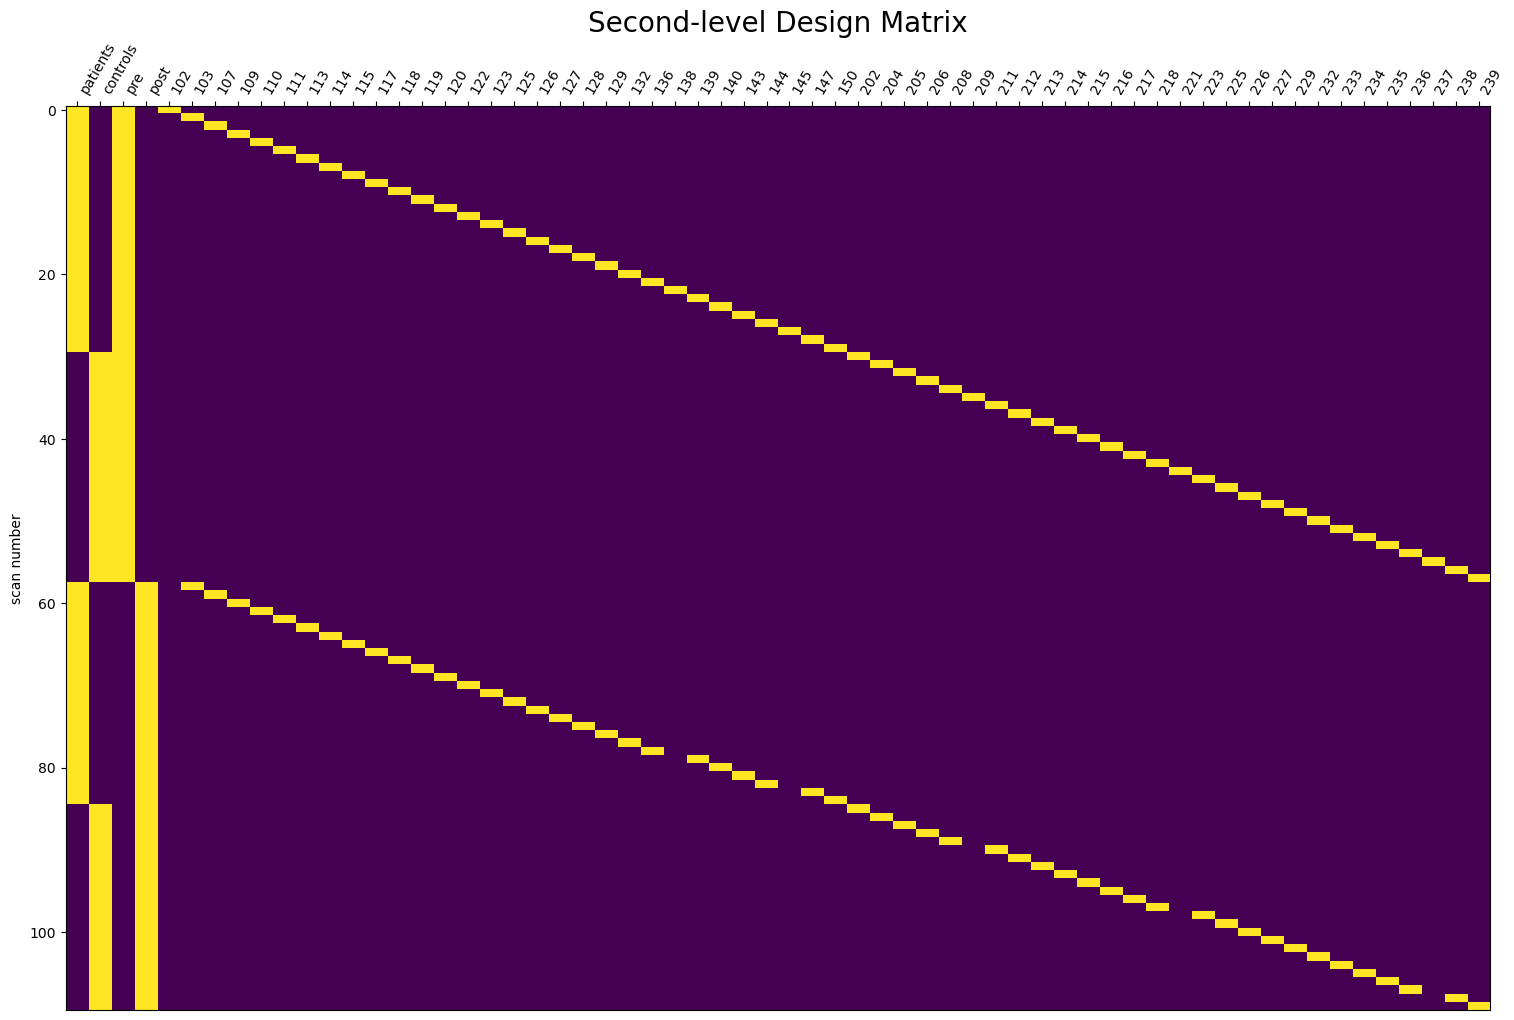

In [294]:
from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(second_level_design_matrix, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

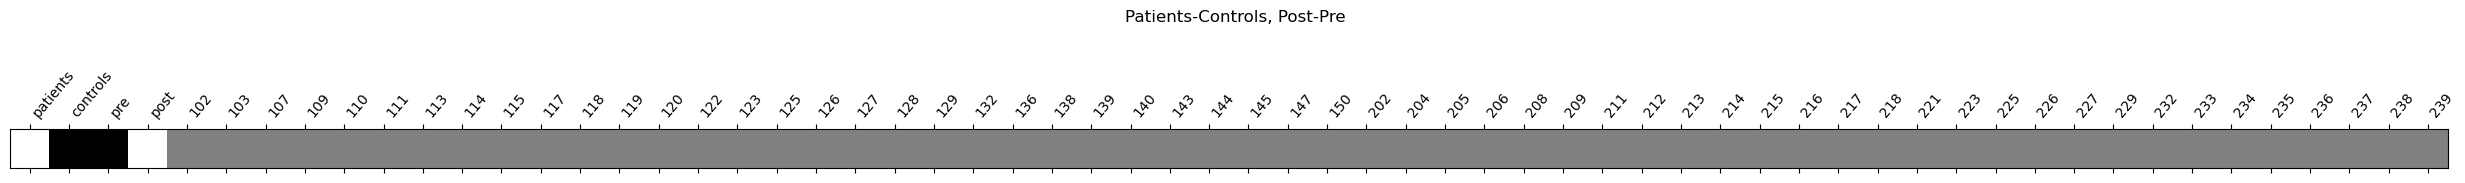

In [295]:
#Making contrasts! 
contrast_matrix = np.eye(second_level_design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(second_level_design_matrix.columns)
    }

contrasts = {
    "Patients-Controls, Post-Pre": (basic_contrasts["patients"]-basic_contrasts["controls"]+basic_contrasts["post"]-basic_contrasts["pre"]),
#    "Post-Pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
#    "Patients-Controls": (basic_contrasts["patients"]-basic_contrasts["controls"]),
    }      
contrasts

from nilearn.plotting import plot_contrast_matrix
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=second_level_design_matrix)
    plt.suptitle(key)
plt.show()

Patients-Controls, Post-Pre; p<0.001 uncorrected


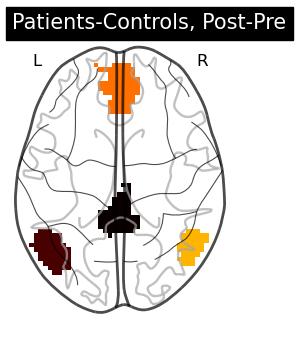

In [299]:
#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

contrast_id = 'Patients-Controls, Post-Pre'    

contrast_val = contrasts[contrast_id] 
print(f"{contrast_id}; p<0.001 uncorrected")

# computing contrast: 
contrast = compute_contrast(secondlevel_labels, secondlevel_estimates, contrast_val)
z_score = contrast.z_score()

plotimg = masker.inverse_transform(z_score)

plotting.plot_glass_brain(
    plotimg,
    display_mode="z",
    title=contrast_id,
    )
plotting.show()

Patients-Controls, Post-Pre; Uncorrected


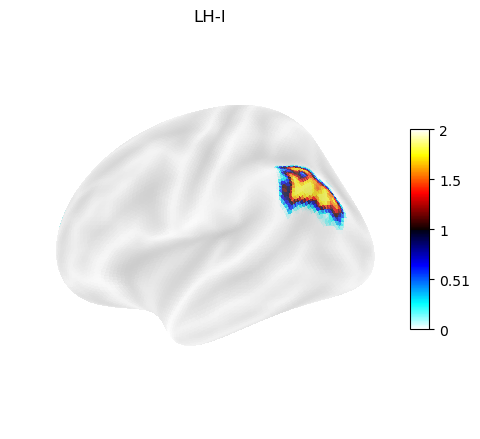

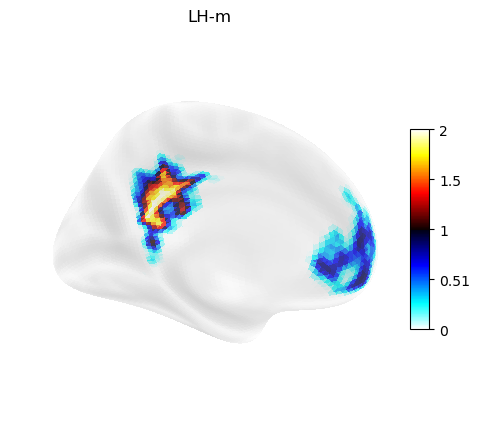

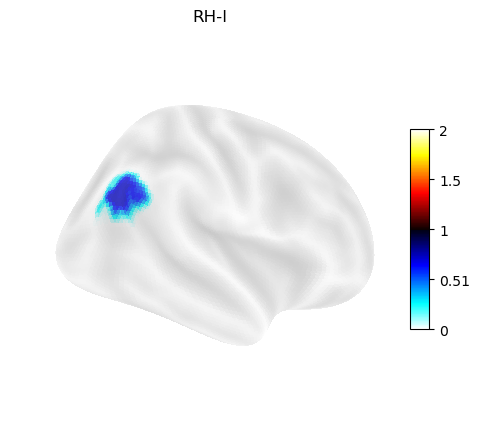

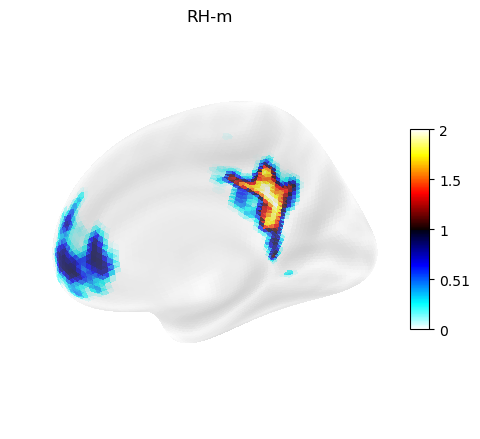

In [309]:
from nilearn import plotting, surface
from nilearn.surface import vol_to_surf

#Plotting surface! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

contrast_id = 'Patients-Controls, Post-Pre'    
contrast_val = contrasts[contrast_id] 
print(f"{contrast_id}; Uncorrected")   

z_map = plotimg

fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")

texture_left = vol_to_surf(z_map, fsaverage.pial_left)
texture_right = vol_to_surf(z_map, fsaverage.pial_right)

plotting.plot_surf_stat_map(fsaverage.infl_left, texture_left, hemi='left', view='lateral',
    title="LH-l", colorbar=True, bg_map=fsaverage.sulc_left, bg_on_data=True)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left, hemi='left', view='medial',
    title="LH-m", colorbar=True, bg_map=fsaverage.sulc_left, bg_on_data=True)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', view='lateral',
    title="RH-l", colorbar=True, bg_map=fsaverage.sulc_right, bg_on_data=True)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right, hemi='right', view='medial',
    title="RH-m", colorbar=True, bg_map=fsaverage.sulc_right, bg_on_data=True)
plotting.show()

In [318]:
contrast.effect_size()
contrast.p_value()

array([0.17160463, 0.02025163, 0.03202417, 0.22872699])

REGION EXTRACTION (EITHER FROM PATIENTS-CONTROLS PRE TREATMENT OR FOR DMN EXTRACTION FROM RESTING STATE) 

In [4]:
# for extracting sig regions -- could use for taking patients-controls sig regions to use as a mask for the omnibus test 

# atlas_networks = preprocessed, cleaned, resting state data 

from nilearn.regions import RegionExtractor

# min_region_size in voxel volume mm^3
extraction = RegionExtractor(
    atlas_networks,
    min_region_size=800,
    threshold=98,
    thresholding_strategy="percentile",
)

# Just call fit() to execute region extraction procedure
extraction.fit()
regions_img = extraction.regions_img_

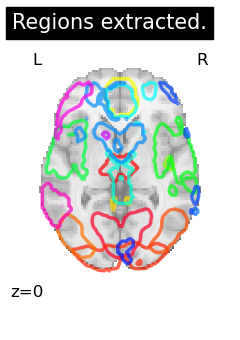

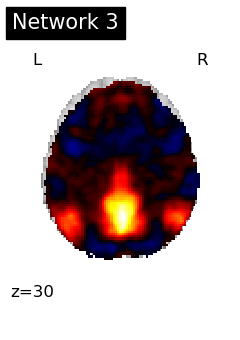

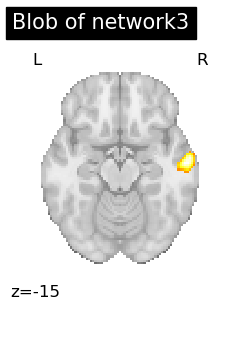

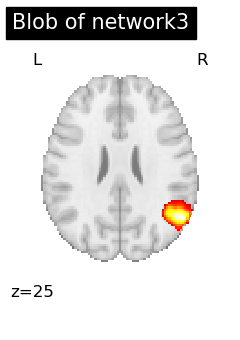

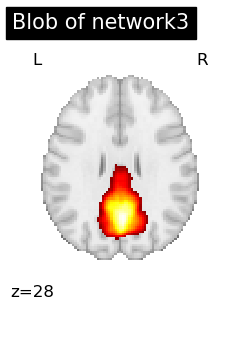

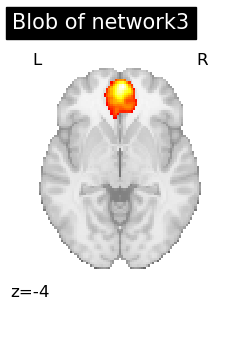

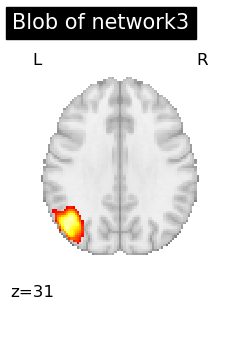

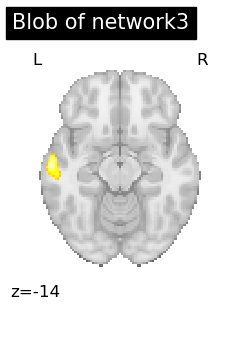

In [10]:
from nilearn import plotting
from nilearn.image import index_img
from nilearn.plotting import find_xyz_cut_coords

# Showing region extraction results using 4D maps visualization tool
plotting.plot_prob_atlas(
    regions_img,
    display_mode="z",
    cut_coords=1,
    view_type="contours",
    title="Regions extracted.",
)

# To reduce the complexity, we choose to display all the regions
# extracted from network 3
import numpy as np

DMN_network = index_img(atlas_networks, 3)
plotting.plot_stat_map(
    DMN_network,
    display_mode="z",
    cut_coords=1,
    title="Network 3",
    colorbar=False,
)

regions_indices_network3 = np.where(np.array(extraction.index_) == 3)
for index in regions_indices_network3[0]:
    cur_img = index_img(extraction.regions_img_, index)
    coords = find_xyz_cut_coords(cur_img)
    plotting.plot_stat_map(
        cur_img,
        display_mode="z",
        cut_coords=coords[2:3],
        title="Blob of network3",
        colorbar=False,
    )

plotting.show()

In [195]:
atlas_networks

'/Users/angelafang/nilearn_data/smith_2009/PNAS_Smith09_rsn10.nii.gz'